In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

In [2]:
LAYER_NAME = 'block5_conv3'  # VGG16
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

In [3]:
def get_img(img_path):
    assert os.path.isfile(img_path)
    img_bgr = cv2.resize(cv2.imread(img_path), (224, 224))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_norm = preprocess_input(np.asarray([np.array(img_rgb)]))
    
    return img_rgb, img_bgr, img_norm

In [4]:
def get_grads(img_norm, cls_idx=-1):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_norm)
        if cls_idx == -1:
            cls_idx = np.argmax(predictions[0]) 
        preds = predictions[:, cls_idx]

    conv_output = conv_outputs[0]
    grads = tape.gradient(preds, conv_outputs)[0]
    
    argmax = np.argmax(predictions[0])

    print(argmax, decode_predictions(predictions.numpy())[0][0])
    
    return grads, conv_output, preds

In [5]:
def synthesize_heatmap(img_bgr, cam, colormap=cv2.COLORMAP_JET, omit_neg=True):
    if omit_neg:
        cam = np.maximum(cam, 0) / np.max(cam)
    else:
        cam = (cam.numpy()-np.min(cam)) / (np.max(cam)-np.min(cam))
    cam = cv2.resize(cam, (img_bgr.shape[0], img_bgr.shape[1]))

    cam = np.uint8(255*cam)
    if colormap is None:
        cam = cv2.cvtColor(cam, cv2.COLOR_GRAY2BGR)
    else:
        cam = cv2.applyColorMap(cam, colormap)
    
    heatmap = cv2.addWeighted(img_bgr.astype('uint8'), 0.5, cam, 1, 0)
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return heatmap

# Grad CAM

### For details on Grad-CAM, see the paper:
###   [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391v1.pdf)

In [6]:
def grad_cam(grads, conv_output):
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(conv_output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_output[:, :, i]
    
    return cam

## Grad CAM++

### For details on GradCAM++, see the paper:
###     [GradCAM++: Improved Visual Explanations for Deep Convolutional Networks](https://arxiv.org/pdf/1710.11063.pdf)

In [7]:
def grad_cam_pp(grads, conv_output, preds):
    score = tf.exp(preds)
    
    first_derivative = score * grads
    second_derivative = first_derivative * grads
    third_derivative = second_derivative * grads

    
    global_sum = np.sum(tf.reshape(conv_output, (-1, conv_output.shape[2])), axis=0)  # [2048]
 
    alpha_denom = second_derivative*2 + third_derivative * tf.reshape(global_sum, (1, 1, conv_output.shape[2])) + 1e-5
    
    alphas = conv_output / alpha_denom  # [10, 10, 2048]
    
    weights = np.maximum(first_derivative, 0)
    
    ## normalize the alphas for each feature map
    alphas_thresh = np.where(weights, alphas, 0)  # threhold the alphas by weights
    alphas_sum = np.sum(alphas_thresh, axis=(0, 1))  # sum the alphas over the feature map, [2048]
    alphas_norm = np.where(alphas_sum!=0, alphas_sum, np.ones(alphas_sum.shape))  
    
    alphas /= alphas_norm
    
    weights = np.maximum(first_derivative, 0) * alphas
    
    weights = np.sum(weights, axis=(0, 1))  # [2048]
    cam = np.zeros(conv_output.shape[0: 2], dtype = np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_output[:, :, i]
    
    return cam

In [8]:
def show_heatmap(img_path, cls_idx=-1, colormap=cv2.COLORMAP_JET, omit_neg=True):
    img_rgb, img_bgr, img_norm = get_img(img_path)
    
    grads, conv_output, preds = get_grads(img_norm, cls_idx=-1)
    
    fig, ax = plt.subplots(ncols=3, figsize=(10, 7), subplot_kw= {'xticks': [], 'yticks': []} )

    ax[0].set_title("Original Image")
    ax[0].imshow(img_rgb)
    
    cam = grad_cam(grads, conv_output)
    heatmap = synthesize_heatmap(img_bgr, cam, colormap, omit_neg)
    ax[1].set_title("Grad CAM")
    ax[1].imshow(heatmap)
    
    cam = grad_cam_pp(grads, conv_output, preds)
    heatmap = synthesize_heatmap(img_bgr, cam, colormap, omit_neg)
    ax[2].set_title("Grad CAM++")
    ax[2].imshow(heatmap)

294 ('n02132136', 'brown_bear', 0.95480734)


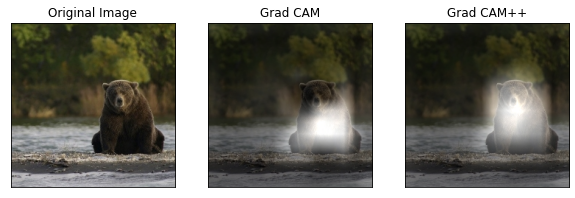

In [9]:
show_heatmap("bear.jpg", colormap=None)

294 ('n02132136', 'brown_bear', 0.95480734)


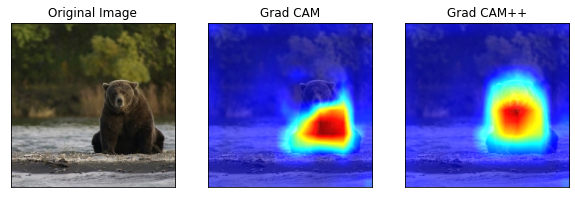

In [10]:
show_heatmap("bear.jpg")

283 ('n02123394', 'Persian_cat', 0.97449183)


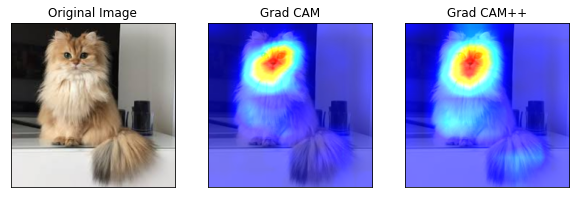

In [11]:
show_heatmap("cat.jpg")

285 ('n02124075', 'Egyptian_cat', 0.33668497)


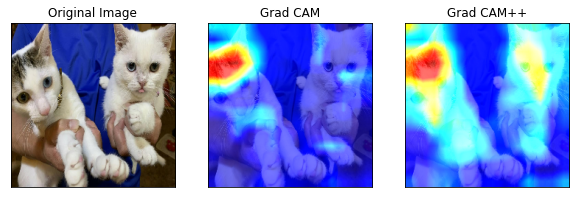

In [12]:
show_heatmap("cat2.jpg")

386 ('n02504458', 'African_elephant', 0.88123584)


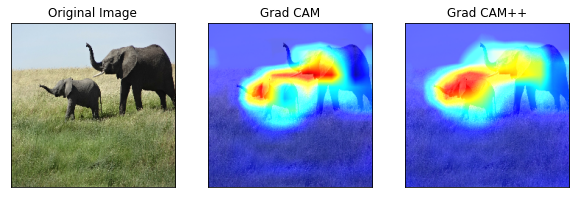

In [13]:
show_heatmap("elephant.jpg")

1 ('n01443537', 'goldfish', 0.9999974)


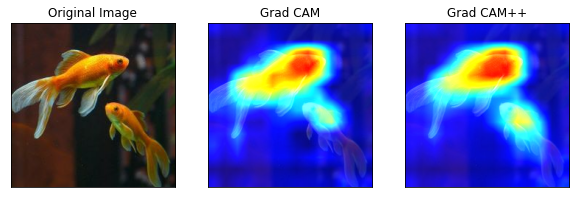

In [14]:
show_heatmap("goldfish.jpg")